In [1]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
import time
#from galsim.gsparams import GSParams
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import shape_measurement as sm

import matplotlib
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font',size=14)

In [2]:
def makeGalaxy(cc, gal_indices, chromatic=False, gsparams=None, trunc_factor=0.):
    import scipy, scipy.special
    galaxies = [ ]
    sersicfit = cc.param_cat['sersicfit']
    for gal_id in gal_indices:
        gal_n = sersicfit[gal_id,2]
        gal_q = sersicfit[gal_id,3]
        gal_phi = sersicfit[gal_id,7]
        gal_hlr = sersicfit[gal_id,1]*np.sqrt(gal_q)*0.03 ## in arcsec
        b_n = 1.992*gal_n-0.3271
        gal_flux = 2*np.pi*gal_n*scipy.special.gamma(2*gal_n)*np.exp(b_n)*gal_q*(sersicfit[gal_id,1]**2)*(sersicfit[gal_id,0])/(b_n**(2.*gal_n))
        #print gal_n, gal_hlr, gal_flux, gal_q, gal_phi
        gal = galsim.Sersic(n=gal_n,half_light_radius=gal_hlr, flux=gal_flux, trunc=trunc_factor*gal_hlr, gsparams=gsparams).shear(q=gal_q,beta=gal_phi*galsim.radians)
        galaxies.append(gal)
    return galaxies


In [3]:
def rotGal(gal,intrinsicTheta, targetTheta):
    '''Rotate galaxy so major axis is rotated targetTheta clockwise relative to x axis'''
    if np.abs(targetTheta) > 2*np.pi:
        print 'warning: targetTheta > 2pi -- recall that targetTheta should be given in radians'
    angle = (targetTheta - intrinsicTheta)*galsim.radians
    return gal.rotate(angle)
rotGalVec = np.vectorize(rotGal)

In [4]:
def measureShapeBasic(gal, epsf, psfIm, ss, *args):
    '''gal: galsim object representing the galaxy profile
       epsf: galsim object representing the effective psf profile (w/ pixel response)
       psfIm: galsim Image of the epsf, *sampled at galaxy rate* (ss)
       ss: float, sampling scale of the galaxy (pixel_scale/gal_oversample)
       Convolves gal+epsf profiles, measures shape w/ regaussianization, returns corrected (e1, e2)'''
    fin = galsim.Convolve(gal, epsf)
    galIm = fin.drawImage(scale=ss, method='no_pixel')
    #plt.imshow(galIm.array);plt.colorbar();x1,x2=45,75;plt.xlim(x1,x2);plt.ylim(x1,x2);plt.show()
    warningMessage = 'Warning: Shape measurement likely wrong, pixel scales differ'
    if galIm.scale != psfIm.scale: print warningMessage
    shape = galsim.hsm.EstimateShear(galIm, psfIm, strict=False)
    if shape.correction_status != 0: 
        return np.nan, np.nan
    else:
        return shape.corrected_e1, shape.corrected_e2
    
def measureShapeReconv(gal, epsf, psf_galsample, galscale, psfii, gsparams):
    '''First four arguments correspond to those of measureShapeBasic
       psfii: interpolated image of the oversampled psf
       Convolve gal+epsf profiles, create interpolated image, de/reconvolve by psfii, measure shape
       Returns corrected (e1, e2) of reconvolved image'''
    fin = galsim.Convolve(gal, epsf)
    given_im = fin.drawImage(scale=galscale, method='no_pixel')
    gal_interp = galsim.InterpolatedImage(given_im, gsparams=gsparams)
    inv_psf = galsim.Deconvolve(psfii)
    dec = galsim.Convolve(gal_interp, inv_psf)
    return measureShapeBasic(dec, psfii, psf_galsample, galscale)

def galShiftErrs(gal, epsf, nx, ss, measureShape=measureShapeBasic, psfii=None, gsparams=galsim.GSParams(kvalue_accuracy=1.e-5,maximum_fft_size=2048*10,maxk_threshold=1.e-5)):
    '''gal, epsf: galsim objects representing galaxy / effective psf profiles
       nx: int, number of steps with which to shift galaxy eg nx=5 shifts by 0, 1/8=1/(2*(nx-1)), 2/8, 3/8, 4/8
       ss: galaxy sampling rate; galaxies will be shifted up to (ss/2, ss/2) in each dimension
       measureShape: function that takes gal, epsf, psfIm, ss, possibly more args, returns (e1, e2)
       psfii: Optional interpolated image of psf, for measureShapeReconv
       Return arrays of e1, e2 measured for each image of a galaxy shifted in an nx x nx grid between (0,0), (ss/2, ss/2)
       inclusive. Psf is not shifted.'''
    d1shifts = np.linspace(0,ss/2, nx)
    aa, bb = np.meshgrid(d1shifts, d1shifts)
    d2shifts = zip(aa.flatten(), bb.flatten())
    psfIm = epsf.drawImage(scale=ss, method='no_pixel')

    e1arr, e2arr = [],[]
    for shift in d2shifts:
        galshift = gal.shift(shift)
        e1, e2 = measureShape(galshift, epsf, psfIm, ss, psfii, gsparams)
        e1arr.append(e1); e2arr.append(e2)
    #print 'Num failures: %d / %d' % (np.sum(np.isnan(e1arr)), len(e1arr))
    return e1arr, e2arr
    #return np.nanmean(e1arr), np.nanmean(e2arr), np.nanstd(e1arr), np.nanstd(e2arr)
    
galShiftErrsVec = np.vectorize(galShiftErrs,otypes=[object,object], excluded=set([1,2,3,'measureShape','psfii','gsparams']))
    

In [5]:
#gsparams=galsim.GSParams()
gsparams = galsim.GSParams(kvalue_accuracy=1.e-5,maximum_fft_size=2048*10,maxk_threshold=1.e-5)
#gsparams = galsim.GSParams(maximum_fft_size=2048*8)

In [32]:
#Set parameters
pixel_scale = 0.1 #as/px
lamda = 1000 #nm
diameter = 1.2 #m
psf_oversample = 5.
gal_oversample = 1.
# Make epsf, draw epsf image, interpolated image
airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
psf = galsim.Convolve(airy, pixel)
given_psf = psf.drawImage(scale=pixel_scale/psf_oversample,method='no_pixel') #Draw oversampled psf image
psf_galsample = psf.drawImage(scale=pixel_scale/gal_oversample,method='no_pixel') #Draw at galaxy scale for shape measurement
psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams)


In [33]:
#Load galaxy catalog and select galaxies
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
sersicfit = cc.param_cat['sersicfit']
hlr, sn, q, phi = [sersicfit[:,i] for i in (1,2,3,7)]

small100I = np.where(np.logical_and(hlr*np.sqrt(q)>2.5, sn>=0.5))[0][400:405] #Large galaxies, reasonable sersic n
gals = makeGalaxy(cc,small100I, chromatic=False, gsparams=gsparams,trunc_factor=0.0)

intrinsicAngles = phi[small100I]
thetas = np.radians(np.arange(0,46,5))
rotGals = np.stack([rotGalVec(gals,intrinsicAngles,targetTheta) for targetTheta in thetas]) #(nrot, ngals) #Confirmed

In [34]:
hlrcut, sncut, qcut = hlr[small100I], sn[small100I], q[small100I] #Not safe with bulges, but there are none at the moment

In [35]:
def gete(q,b):
    shear = galsim.shear.Shear(q=q, beta=b*galsim.radians)
    return np.array([shear.e1, shear.e2])
q0 = q[small100I]
QQ, THTH = np.meshgrid(q0, thetas)
shearVec = np.vectorize(gete, otypes=[object])
trueShears = shearVec(QQ, THTH)
trueShears = np.stack([np.stack(x) for x in trueShears]) #(nrot, ngals, (e1, e2))

In [36]:
sh=trueShears.shape
trueShearsExt = trueShears.reshape((sh[0],sh[1],1,sh[2]))
trueShearsExt = np.repeat(trueShearsExt,2,axis=2)

In [37]:
nx = 5
ss = pixel_scale / gal_oversample

reconv = galShiftErrsVec(rotGals, psf, nx, ss, measureShapeReconv, psfii, gsparams)
orig= galShiftErrsVec(rotGals,psf,nx,ss)

reconv = np.stack([np.stack([np.stack(x) for x in a]) for a in reconv]).transpose(1,2,0,3) #nrot, ngal, (e1, e2), movedCenter (nx x nx)
orig = np.stack([np.stack([np.stack(x) for x in a]) for a in orig]).transpose(1,2,0,3)

In [38]:
origMean, origStd = np.nanmean(orig,axis=-1), np.nanstd(orig,axis=-1)
reconvMean, reconvStd = np.nanmean(reconv, axis=-1), np.nanstd(reconv, axis=-1)
recOrigDiff = reconv - orig
recOrigDiffMean, recOrigDiffStd = np.nanmean(recOrigDiff, axis=-1), np.nanstd(recOrigDiff, axis=-1)


In [39]:
diffShapes = np.stack([origMean - trueShears, reconvMean - trueShears, recOrigDiffMean]).transpose(0,3,2,1)
diffShapesErr = np.stack([origStd, reconvStd, recOrigDiffStd]).transpose(0,3,2,1)


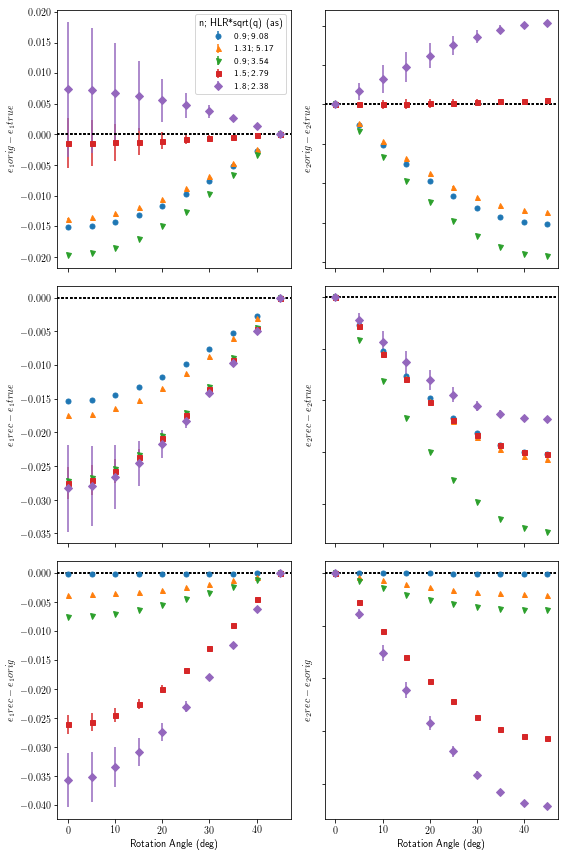

In [42]:
order = np.argsort(hlrcut*np.sqrt(qcut))[::-1] #Descending order of circularized hlr
labels=['%s; %s' % (snl,hlrc) for (snl,hlrc) in zip(np.round(sncut,2)[order], np.round(hlrcut*qcut,2)[order])]
markers=['o','^','v','s','D']
orderedDiffShapes = diffShapes[:,:,order,:]
orderedDiffShapeErrs = diffShapesErr[:,:,order,:]
fig,ax = plt.subplots(3,2,figsize = (8,12),sharex = True)
names = np.array([['$e_1orig - e_1true$','$e_1rec - e_1true$', '$e_1rec - e_1orig$'],\
                  ['$e_2orig - e_2true$','$e_2rec - e_2true$', '$e_2rec - e_2orig$']]).transpose()
for i in range(3): # orig-true; rec-true; rec-orig
    for j in range(2): #e1, e2
        sp = orderedDiffShapes[i,j]
        for galnum,spp in enumerate(sp): #galaxies
            name=names[i,j]
            subax=ax[i,j]
            subax.errorbar(np.degrees(thetas), spp, yerr=orderedDiffShapeErrs[i,j,galnum], \
                           fmt='.',label=labels[galnum],marker=markers[galnum],markersize=5)#label='Gal %d'%(galnum))
            if i==2: subax.set_xlabel('Rotation Angle (deg)')
            subax.set_ylabel(name)
            subax.axhline(0.0,c='k', linestyle=':')
            #subax.legend()
ax[0,0].legend(loc='upper right',title='n; HLR*sqrt(q) (as)',fontsize=9)
for i in range(3):
    ax[i,1].get_shared_y_axes().join(ax[i,1], ax[i,0])
    ax[i,1].set_yticklabels([])
ax[0,0].get_shared_y_axes().join(ax[1,0],ax[0,0])
yl1,yl2 = ax[0,0].get_ylim(), ax[1,0].get_ylim()
yl = (min(yl1[0],yl2[0]),max(yl1[1],yl2[1]))
# ax[0,0].set_ylim(yl)
# ax[1,0].set_ylim(yl)

#ax[2,0].set_ylim(-0.004,0.0002)
plt.tight_layout()

#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/reconvolve_bias_rotation_errs_1000nm_galos1.pdf')

In [16]:
ax[0,0].get_ylim()

(-0.03323587414950324, 0.136723304237081)

In [17]:
galparams = np.round(np.stack([hlrcut, qcut, sncut]).transpose(), 2)[order]
print 'hlr (px), q, sersic n'
print galparams
#gal_hlr = sersicfit[gal_id,1]*np.sqrt(gal_q)*0.03 ## in arcsec


hlr (px), q, sersic n
[[13.71  0.66  0.9 ]
 [ 6.78  0.76  1.31]
 [ 8.9   0.4   0.9 ]
 [ 6.21  0.45  1.5 ]
 [ 6.32  0.38  1.8 ]]
